<a href="https://colab.research.google.com/github/promckkon/1DCNN/blob/main/MK-DCNN%20with%200%20NOISE%20in%20CWRU%20Dataset%20251118.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [182]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F1_B007_1_124.mat
['F1_B007_1_124']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F2_B014_1_191.mat


/tmp/ipython-input-4247073321.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F1_B007_1_124' 'F2_B014_1_191']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F3_B021_1_228.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F4_IR007_1_111.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F5_IR014_1_176.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F6_IR021_1_215.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176' 'F6_IR021_1_215']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F7_OR007_6_1_137.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176' 'F6_IR021_1_215' 'F7_OR007_6_1_137']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/F8_OR014_6_1_203.mat
['F1_B007_1_124' 'F2_B014_1_191' 'F3_B021_1_228' 'F4_IR007_1_111'
 'F5_IR014_1_176' 'F6_IR021_1_215' 'F7_OR007_6_1_137' 'F8_OR014_6_1_203']
/content

# Multi-Kernel Deep 1D-CNN

In [183]:
pip install tensorflow

In [184]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [185]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [186]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 10


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 2706, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 2507, 64)  │     12,864 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 2607, 64)  │      6,464 │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 2657, 64)  │      3,264 │ input_layer_20[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 2507, 64)  │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 2607, 64)  │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 2657, 64)  │          0 │ conv1d_20[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_18    │ (None, 125, 64)   │          0 │ dropout_18[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_19    │ (None, 260, 64)   │          0 │ dropout_19[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_20    │ (None, 531, 64)   │          0 │ dropout_20[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 8000)      │          0 │ max_pooling1d_18… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 16640)     │          0 │ max_pooling1d_19… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 33984)     │          0 │ max_pooling1d_20… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 58624)     │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 100)       │  5,862,500 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 10)        │      1,010 │ dense_12[0][0]  

 Total params: 5,886,102 (22.45 MB)

 Trainable params: 5,886,102 (22.45 MB)

 Non-trainable params: 0 (0.00 B)

In [187]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 477ms/step - accuracy: 0.1393 - loss: 4.1675 - val_accuracy: 0.1917 - val_loss: 1.8997
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2734 - loss: 1.6867 - val_accuracy: 0.3418 - val_loss: 1.6241
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4362 - loss: 1.3833 - val_accuracy: 0.6226 - val_loss: 1.3031
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6715 - loss: 0.9274 - val_accuracy: 0.8321 - val_loss: 0.9131
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8833 - loss: 0.4901 - val_accuracy: 0.8484 - val_loss: 0.6132
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9255 - loss: 0.2599 - val_accuracy: 0.8856 - val_loss: 0.4474
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9549 - loss: 0.1621 - val_accuracy: 0.8574 - val_loss: 0.4856
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9574 - loss: 0.1618 - val_accuracy: 0.8871 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


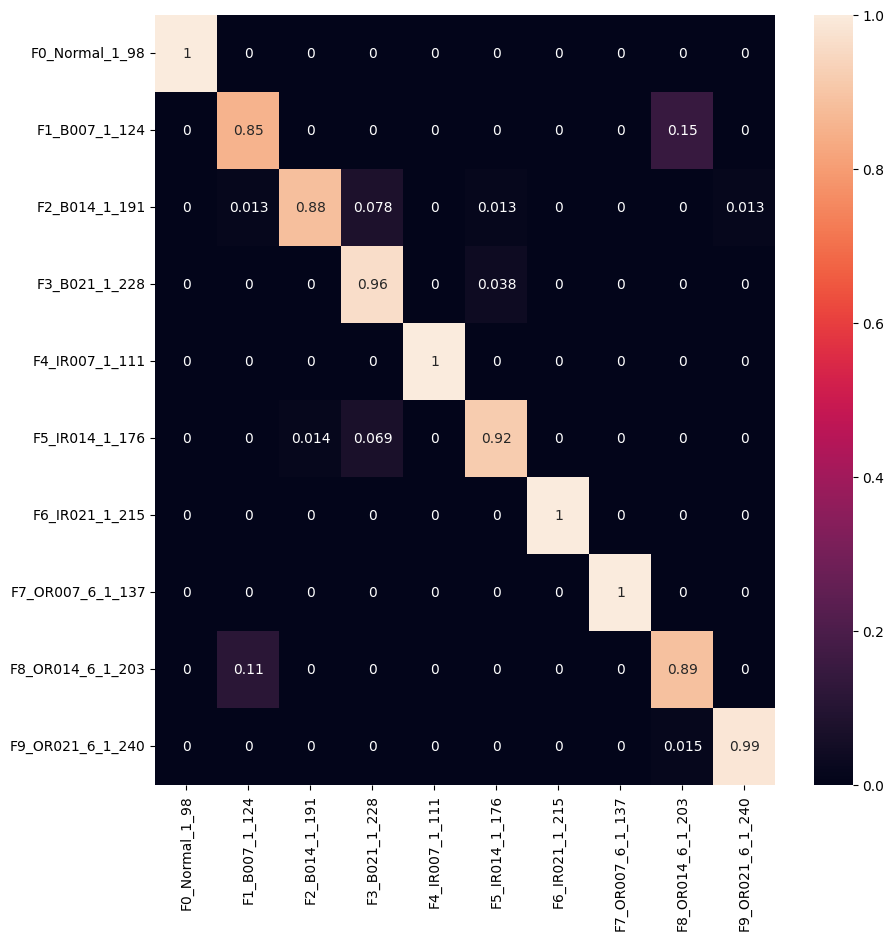

In [188]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [189]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...
[t-SNE] Computed neighbors for 1570 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 2.124774
[t-SNE] Computed conditional probabilities in 0.056s


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 50: error = 56.6206245, gradient norm = 0.0340030 (50 iterations in 0.648s)
[t-SNE] Iteration 100: error = 51.9628372, gradient norm = 0.0139470 (50 iterations in 0.518s)
[t-SNE] Iteration 150: error = 50.8184853, gradient norm = 0.0108438 (50 iterations in 0.461s)
[t-SNE] Iteration 200: error = 50.2657127, gradient norm = 0.0068754 (50 iterations in 0.447s)
[t-SNE] Iteration 250: error = 49.9319954, gradient norm = 0.0050537 (50 iterations in 0.460s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.931995
[t-SNE] Iteration 300: error = 0.8718354, gradient norm = 0.0170656 (50 iterations in 0.467s)
[t-SNE] Iteration 350: error = 0.6045149, gradient norm = 0.0143849 (50 iterations in 0.481s)
[t-SNE] Iteration 400: error = 0.5065347, gradient norm = 0.0120049 (50 iterations in 0.479s)
[t-SNE] Iteration 450: error = 0.4586733, gradient norm = 0.0104374 (50 iterations in 0.472s)
[t-SNE] Iteration 500: error = 0.4311541, gradient norm = 0.0092028 (50 

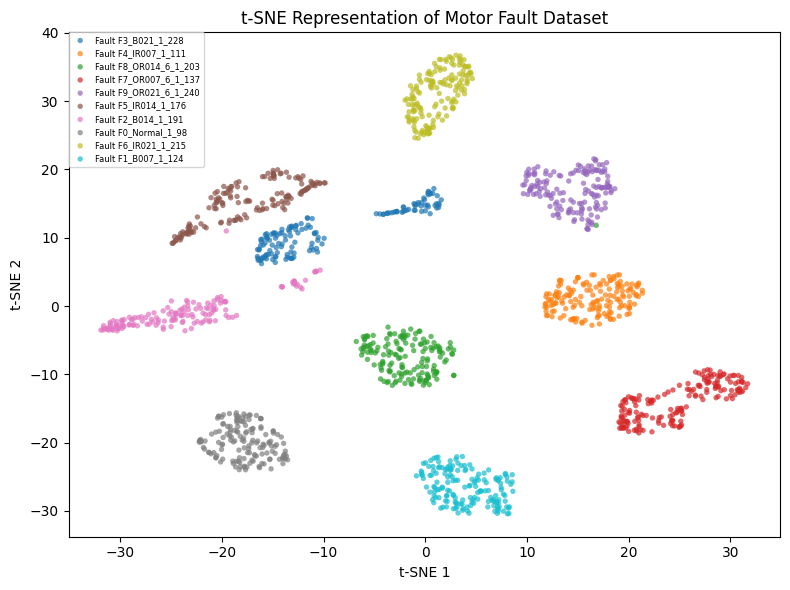

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}',s=20, alpha=0.7,edgecolors='none')

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(
    loc='upper left',             # 以左上為基準

    borderaxespad=0.,
    fontsize=6,                   # 再縮小字體
    title_fontsize=7,
    markerscale=1,              # 圖例裡的小點也縮小
    framealpha=0.8                # 半透明，避免太遮
)
plt.tight_layout()
plt.show()

Statistical Features

In [191]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2706, STRIDE: 2164
Extracted 2243 rows (target: 1800)
               fault  window      mean       std       rms       max  \
0      F1_B007_1_124       1  0.014919  0.155983  0.156694  0.585375   
1      F1_B007_1_124       2  0.015372  0.145547  0.146357  0.585375   
2      F1_B007_1_124       3  0.016878  0.140657  0.141666  0.414936   
3      F1_B007_1_124       4  0.016009  0.123387  0.124421  0.438092   
4      F1_B007_1_124       5  0.016391  0.135949  0.136933  0.515906   
...              ...     ...       ...       ...       ...       ...   
2238  F0_Normal_1_98     219  0.013966  0.066277  0.067733  0.220089   
2239  F0_Normal_1_98     220  0.015203  0.064545  0.066311  0.211536   
2240  F0_Normal_1_98     221  0.016827  0.061149  0.063422  0.188588   
2241  F0_Normal_1_98     222  0.015862  0.072285  0.074005  0.317513   
2242  F0_Normal_1_98     223  0.015302  0.066122  0.067869  0.196307   

           min  skewness  kurtosis  form_factor  crest_fa

In [192]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
F6_IR021_1_215      226
F5_IR014_1_176      225
F9_OR021_6_1_240    225
F1_B007_1_124       224
F2_B014_1_191       224
F4_IR007_1_111      224
F3_B021_1_228       224
F7_OR007_6_1_137    224
F8_OR014_6_1_203    224
F0_Normal_1_98      223
Name: count, dtype: int64
Current rows after equal resampling: 1570
New class distribution:
fault
F0_Normal_1_98      157
F3_B021_1_228       157
F9_OR021_6_1_240    157
F7_OR007_6_1_137    157
F4_IR007_1_111      157
F1_B007_1_124       157
F6_IR021_1_215      157
F5_IR014_1_176      157
F2_B014_1_191       157
F8_OR014_6_1_203    157
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [193]:
balanced_df.shape

(1570, 11)

In [194]:
balanced_df=balanced_df.sort_values(by='fault')

In [195]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F0_Normal_1_98,43,0.009751,0.065139,0.065864,0.212996,-0.215708,-0.274433,-0.045461,1.236035,3.233858
412,F0_Normal_1_98,126,0.009053,0.065878,0.066497,0.207990,-0.209450,-0.182528,0.069087,1.252104,3.127817
418,F0_Normal_1_98,39,0.009913,0.066629,0.067362,0.214457,-0.243246,-0.129796,-0.097380,1.238133,3.183623
421,F0_Normal_1_98,41,0.009056,0.062323,0.062978,0.181078,-0.183999,-0.064707,-0.311857,1.232367,2.875268
434,F0_Normal_1_98,171,0.014931,0.068058,0.069677,0.243871,-0.235944,-0.167390,-0.017621,1.233601,3.500033
...,...,...,...,...,...,...,...,...,...,...,...
671,F9_OR021_6_1_240,37,0.019118,0.764205,0.764444,6.993672,-6.522920,-0.190572,27.035617,2.207795,9.148707
992,F9_OR021_6_1_240,68,0.015919,0.368323,0.368667,2.281144,-2.346248,-0.327045,7.737874,1.589529,6.187542
1004,F9_OR021_6_1_240,65,0.016095,0.570980,0.571206,4.146624,-4.914517,-0.877848,22.789508,2.140498,7.259415
317,F9_OR021_6_1_240,45,0.015551,0.652645,0.652830,3.912083,-4.865272,-0.570812,12.225455,1.778703,5.992494


     t-SNE 1    t-SNE 2           fault
0  21.096661 -26.604923  F0_Normal_1_98
1  38.854210  -0.627963  F0_Normal_1_98
2  23.185158   5.936248  F0_Normal_1_98
3  29.454052  24.890530  F0_Normal_1_98
4  37.877728  23.811205  F0_Normal_1_98


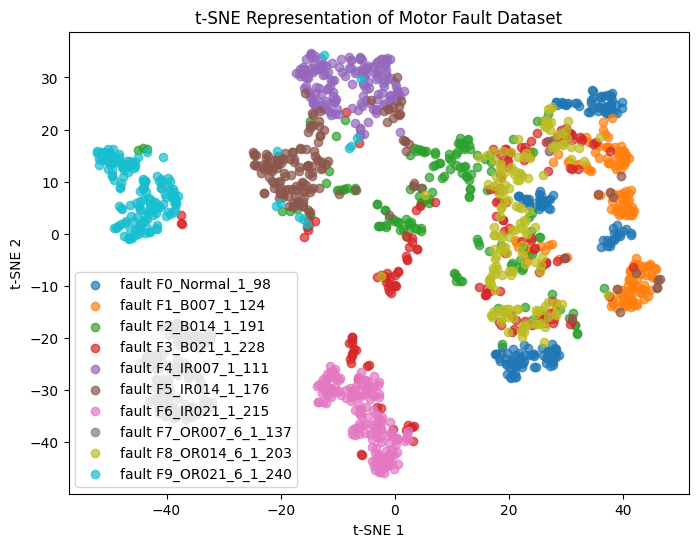

In [196]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [197]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,21.096661,-26.604923,F0_Normal_1_98
1,38.854210,-0.627963,F0_Normal_1_98
2,23.185158,5.936248,F0_Normal_1_98
3,29.454052,24.890530,F0_Normal_1_98
4,37.877728,23.811205,F0_Normal_1_98
...,...,...,...
1565,-43.904247,3.423827,F9_OR021_6_1_240
1566,-44.669025,1.937468,F9_OR021_6_1_240
1567,-46.347141,13.944497,F9_OR021_6_1_240
1568,-51.305405,15.452444,F9_OR021_6_1_240


In [198]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,21.096661,-26.604923
1,38.854210,-0.627963
2,23.185158,5.936248
3,29.454052,24.890530
4,37.877728,23.811205
...,...,...
1565,-43.904247,3.423827
1566,-44.669025,1.937468
1567,-46.347141,13.944497
1568,-51.305405,15.452444


In [199]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [200]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
1324,-17.818604,-16.925236,F0_Normal_1_98
185,-15.377031,-19.944386,F0_Normal_1_98
1326,-16.754694,-21.942686,F0_Normal_1_98
1097,-20.805361,-21.466377,F0_Normal_1_98
192,-18.012020,-19.618658,F0_Normal_1_98
...,...,...,...
594,15.671289,15.214082,F9_OR021_6_1_240
1446,17.346203,17.304358,F9_OR021_6_1_240
201,14.821621,19.882734,F9_OR021_6_1_240
863,17.951061,19.012203,F9_OR021_6_1_240


Combined Features

In [201]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
1324,26.464540,20.527519,-17.818604,-16.925236,F0_Normal_1_98
185,41.278252,-6.875815,-15.377031,-19.944386,F0_Normal_1_98
1326,19.566069,-15.068976,-16.754694,-21.942686,F0_Normal_1_98
1097,-0.980314,-43.880314,-20.805361,-21.466377,F0_Normal_1_98
192,27.757460,13.789750,-18.012020,-19.618658,F0_Normal_1_98
...,...,...,...,...,...
594,3.000394,-1.649409,15.671289,15.214082,F9_OR021_6_1_240
1446,-44.624298,8.141638,17.346203,17.304358,F9_OR021_6_1_240
201,39.280819,4.465748,14.821621,19.882734,F9_OR021_6_1_240
863,-18.440487,5.285286,17.951061,19.012203,F9_OR021_6_1_240


In [202]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [203]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

y_shuffled = np.random.permutation(y)

In [204]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2    ,random_state=42,
    shuffle=True,
    stratify=y  )

In [205]:
!pip install catboost

Deployment:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.2647423	test: 2.2645619	best: 2.2645619 (0)	total: 4.15ms	remaining: 411ms
50:	learn: 1.1652129	test: 1.1708817	best: 1.1708817 (50)	total: 136ms	remaining: 131ms
99:	learn: 0.7468484	test: 0.7546446	best: 0.7546446 (99)	total: 262ms	remaining: 0us

bestTest = 0.7546445821
bestIteration = 99

Train Accuracy: 0.9570
Test  Accuracy: 0.9586

Classification Report - Training Set:
                  precision    recall  f1-score   support

  F0_Normal_1_98       1.00      1.00      1.00       122
   F1_B007_1_124       1.00      1.00      1.00       129
   F2_B014_1_191       0.97      0.98      0.97       117
   F3_B021_1_228       0.95      0.59      0.73       117
  F4_IR007_1_111       1.00      1.00      1.00       129
  F5_IR014_1_176       0.84      0.98      0.90       122
  F6_IR021_1_215       0.85      1.00      0.92       124
F7_OR007_6_1_137       1.00      1.00      1.00       141
F8_OR014_6_1_203       1.00      0.99      1.00       129
F9_OR021_6_1_240       0.99 

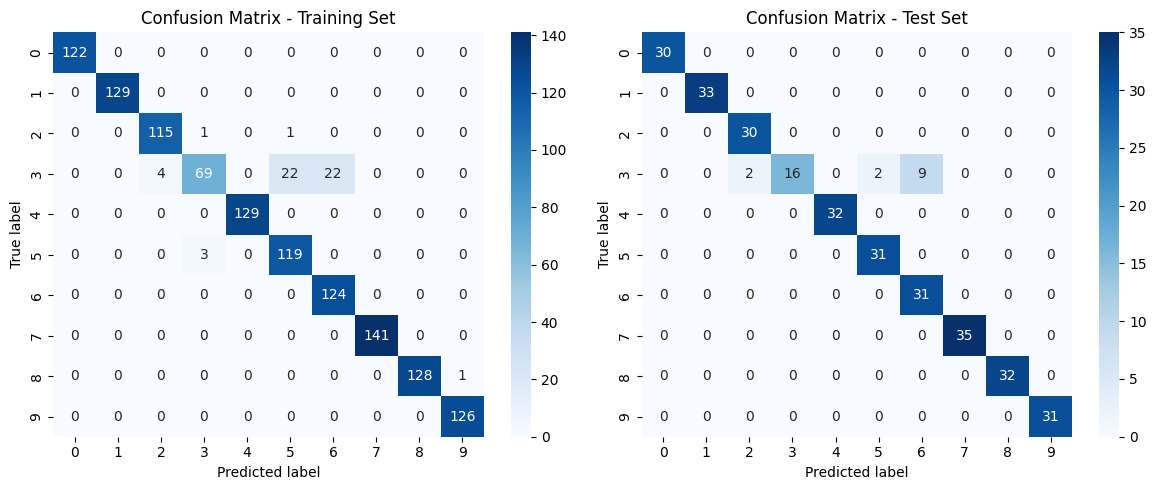

In [207]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

cat_model = CatBoostClassifier(
    iterations=100,
    depth=4,
    learning_rate=0.01,
    l2_leaf_reg=5,
    bagging_temperature=1.5,
    random_strength=1.5,
    random_seed=42,
    verbose=50
)

# === 訓練模型 ===
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),  # 用測試集當驗證集看學習曲線
    plot=True                   # 在 Colab 畫出學習曲線
)
# ========= 1. 對 Train / Test 都做預測 =========
y_train_pred = cat_model.predict(X_train)
y_test_pred  = cat_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc  = accuracy_score(y_test,  y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}\n")

# ========= 2. 印出 Train Set 的分類報告 =========
print("Classification Report - Training Set:")
print(classification_report(y_train, y_train_pred))

# ========= 3. 印出 Test Set 的分類報告 =========
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred))

# ========= 4. 混淆矩陣：Train / Test 各一個 =========
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test  = confusion_matrix(y_test,  y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Training Set")
axes[0].set_xlabel("Predicted label")
axes[0].set_ylabel("True label")

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Test Set")
axes[1].set_xlabel("Predicted label")
axes[1].set_ylabel("True label")

plt.tight_layout()
plt.show()